In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

In [18]:
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')

In [35]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [36]:
# Observe possible values for categorical variables (except for ID).

for col in df[['gender','ever_married','work_type','Residence_type','smoking_status']]:
    print(col, df[col].unique())

gender ['Male' 'Female' 'Other']
ever_married ['Yes' 'No']
work_type ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type ['Urban' 'Rural']
smoking_status ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [37]:
print(df['gender'].value_counts())
print(df['hypertension'].value_counts())
print(df['heart_disease'].value_counts())
print(df['smoking_status'].value_counts())

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
0    4612
1     498
Name: hypertension, dtype: int64
0    4834
1     276
Name: heart_disease, dtype: int64
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


C:\Users\User\AppData\Local\Temp/ipykernel_12364/99531822.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df[['age','avg_glucose_level','bmi']].hist(ax = ax)


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'avg_glucose_level'}>],
       [<AxesSubplot:title={'center':'bmi'}>, <AxesSubplot:>]],
      dtype=object)

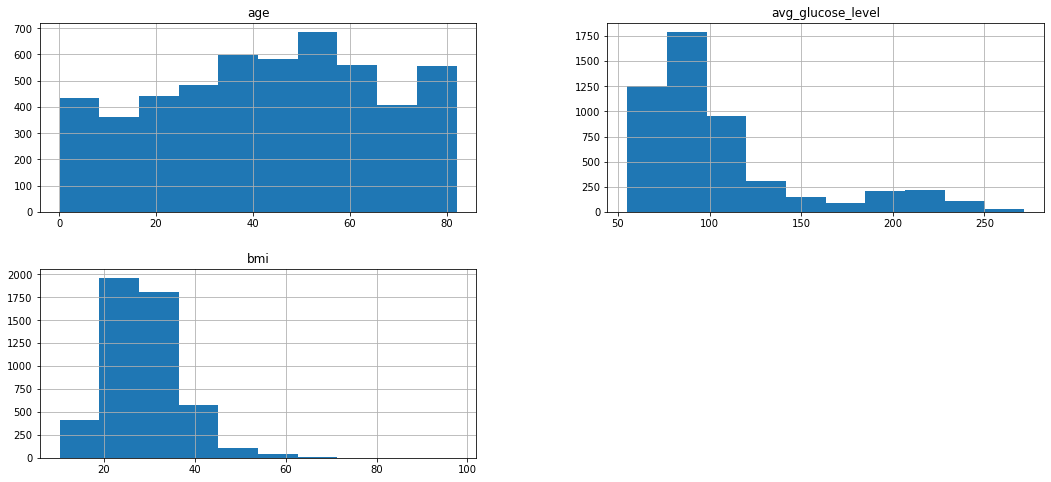

In [38]:
# Observe range of continuous variables
fig = plt.figure(figsize = (18,8))
ax = fig.gca()
df[['age','avg_glucose_level','bmi']].hist(ax = ax)

In the above variables, 'Age' contains negative values, which is a data error. The remaining variables appear to exhibit otherwise possible range of values.

In [19]:
# Clean up categorical value names 
df = df.replace({'work_type': {'Private': 'Private Industry', 'Govt_job': 'Government Job', 'children': 'Not of Working Age','Never_worked':'Not of Working Age'}})
df = df.replace({'smoking_status': {'formerly smoked': 'Former Smoker', 'never smoked': 'Never Smoked', 'smokes': 'Smoker'}})

df = df.rename(columns={'gender': 'Is_Male', 'Residence_type':'Is_Urban_Residence'})
df = df.loc[df['Is_Male']!= 'Other']
df['age'] = df['age'].apply(lambda x: math.ceil(x))

# Subsequently, replace all Yes/No categorical variables as well as Gender with Boolean values
df = df.replace({'Is_Male': {'Male': 1, 'Female': 0}, 'Is_Urban_Residence': {'Urban': 1, 'Rural': 0},'ever_married': {'Yes': 1, 'No': 0}})

df = df.astype({'stroke': 'bool'})

In [20]:
df.dtypes

id                      int64
Is_Male                 int64
age                     int64
hypertension            int64
heart_disease           int64
ever_married            int64
work_type              object
Is_Urban_Residence      int64
avg_glucose_level     float64
bmi                   float64
smoking_status         object
stroke                   bool
dtype: object

In [5]:
# Check 'ID' for duplicates
len(df['id']) - (df['id']).nunique()

0

In [21]:
# Drop ID column
df = df.drop(['id'],axis=1)

In [7]:
# Check for null/missing values among variables.
pd.DataFrame(df.isnull().mean()*100, columns = ['% Missing']).sort_values(by = '% Missing', ascending=False).round(1)

,% Missing
bmi,3.9
Is_Male,0.0
age,0.0
hypertension,0.0
heart_disease,0.0
ever_married,0.0
work_type,0.0
Is_Urban_Residence,0.0
avg_glucose_level,0.0
smoking_status,0.0


,bmi
count,4908.00
mean,28.89
std,7.85
min,10.30
25%,23.50
50%,28.10
75%,33.10
max,97.60


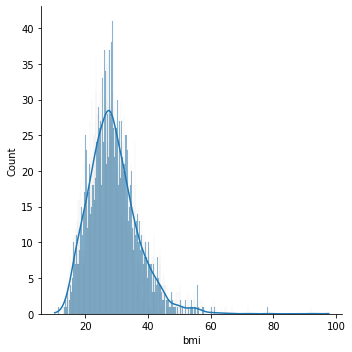

In [10]:
# Display summary statistics
display(df[["bmi"]].describe().round(2))
sns.displot(df, x = "bmi", binwidth=0.1, kde = True)

Looking at the summary statistics, the distribution of values for BMI measurements are normally distributed around the mean, with a right skew.
<br>Hence, we will opt to <b>impute</b> missing values in BMI via the Median. Given the skew in the attendance distribution, a median approach will result in a more representative imputation over using the mean.

In [28]:
# Impute median values for 'bmi'
df_final = df.copy()
df_final['bmi'] = df_final['bmi'].fillna(df_final['bmi'].median())

In [29]:
print('Post-cleaning Dataset:', df_final.shape[0], 'records')

Post-cleaning Dataset: 5109 records


<AxesSubplot:>

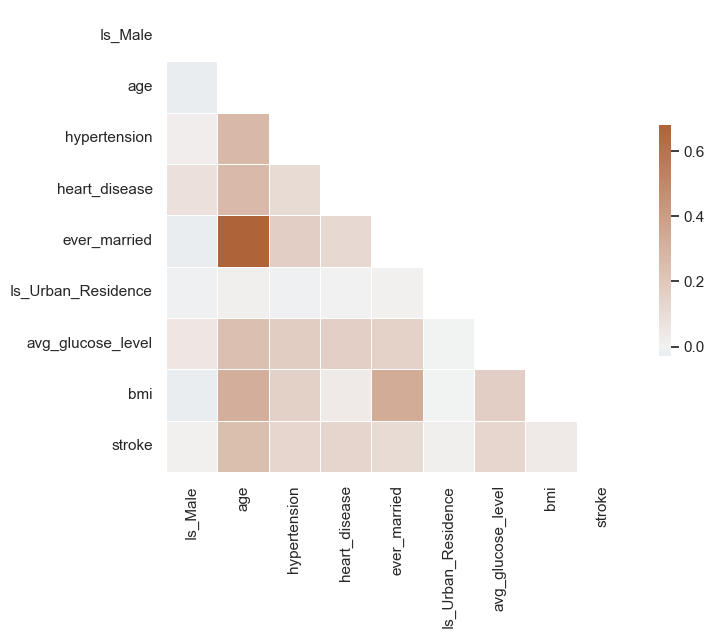

In [24]:
corr = df_final.corr()

sns.set_theme(style="white")

f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(230, 30, as_cmap=True)
sns.heatmap(corr, mask = np.triu(np.ones_like(corr, dtype=bool)), cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Pairwise correlations show one pair with stronger than 0.5 correlation: ever_married and age, which is ~0.6x correlated. We will keep both attribute pairs for modelling, as our threshold for collinearity is any pair stronger than 0.75.

In [31]:
df_target = df_final[['stroke']]
df_final = df_final.drop(['stroke'], axis=1)
df_final = pd.get_dummies(df_final, columns = ['work_type','smoking_status'])
df_final = df_final.join(df_target)

In [33]:
df_final['stroke'].value_counts()

False    4860
True      249
Name: stroke, dtype: int64